In [18]:
%run initialising.ipynb

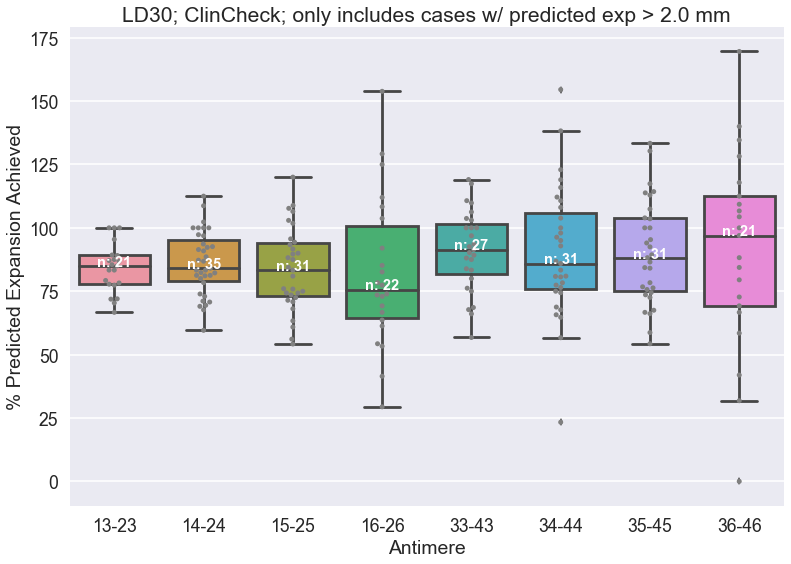

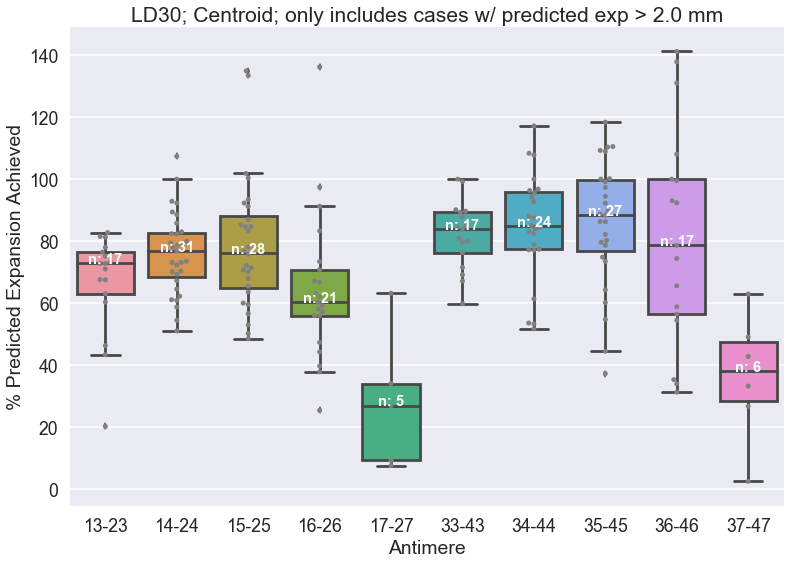

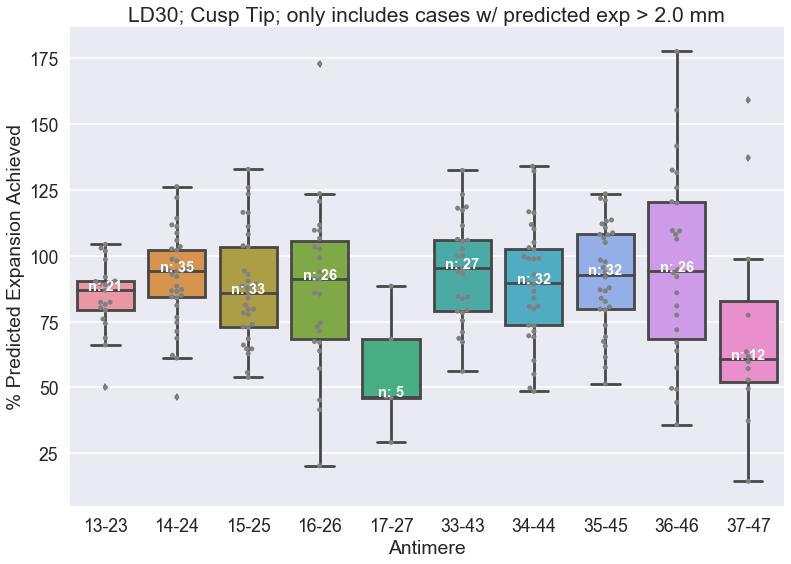

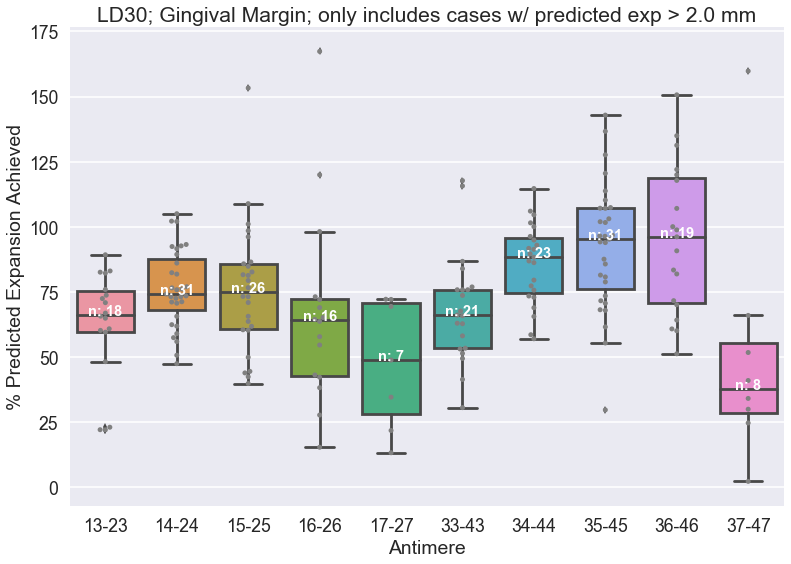

In [14]:
def boxPlot(df, measure_type, threshold, material):
    '''Boxplot: %Accuracy vs Antimere for a given measure_type & material.
    Only includes data where predicted exp > threshold.
    Also outputs .PDF of data.
    '''
    
    pp = PdfPages(os.path.join(OUTPUT_DIR, 'boxplots/boxplots-%s%s.pdf' % (material, measure_type)))
    
    sns.set('poster', font_scale=1.1)
    f = plt.figure()
    
    newDf = pd.DataFrame(columns = ['%acc', 'antimere', 'material'])
    
    subDf = getSubDf(df, measure_type, THRESHOLD, material)
    for i, j in zip([1, 3], [2, 4]):
        for toothNum in range(3, 8):

            if measure_type == '.cc' and toothNum == 7:
                continue

            antimere = '%s%s-%s%s' % (i, toothNum, j, toothNum)
            full_antimere = '%s%s-%s%s%s %%acc' % (i, toothNum, j, toothNum, measure_type)

            #antimere df
            amDf = pd.DataFrame(subDf[full_antimere].dropna())
            amDf = amDf.rename(columns = lambda x: str(x)[-4:])
            amDf['antimere'] = antimere
            amDf['material'] = material

            newDf = pd.concat([newDf, amDf], ignore_index=True)

    bplot = sns.boxplot(x='antimere', y='%acc', data=newDf)
    bplot = sns.swarmplot(x='antimere', y='%acc', data=newDf, color="grey")

    ### Adding n to boxplot.
    # Calculate number of obs & median to position labels
    medians = newDf.groupby(['antimere'])['%acc'].median().values
    nobs = newDf.groupby(['antimere'])['%acc'].count().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]
    # Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,bplot.get_xticklabels()):
        bplot.text(pos[tick], medians[tick] + 0.03, nobs[tick],
        horizontalalignment='center', size='x-small', color='w', weight='semibold')

    # Set titles
    bplot.axes.set_title("%s; %s; only includes cases w/ predicted exp > %s mm" % (material, measure_type_dict[measure_type], threshold))
    bplot.set_xlabel("Antimere")
    bplot.set_ylabel("% Predicted Expansion Achieved")
    
    sns.plt.show()
    pp.savefig(f, bbox_inches="tight")
    pp.close()
    return

for measure_type in MEASURE_TYPES:
    boxPlot(df, measure_type, THRESHOLD, 'LD30')

In [3]:
getColumn(df, '13-23.gm %acc', '13-23', 2, '.gm', 'LD30').count()

18

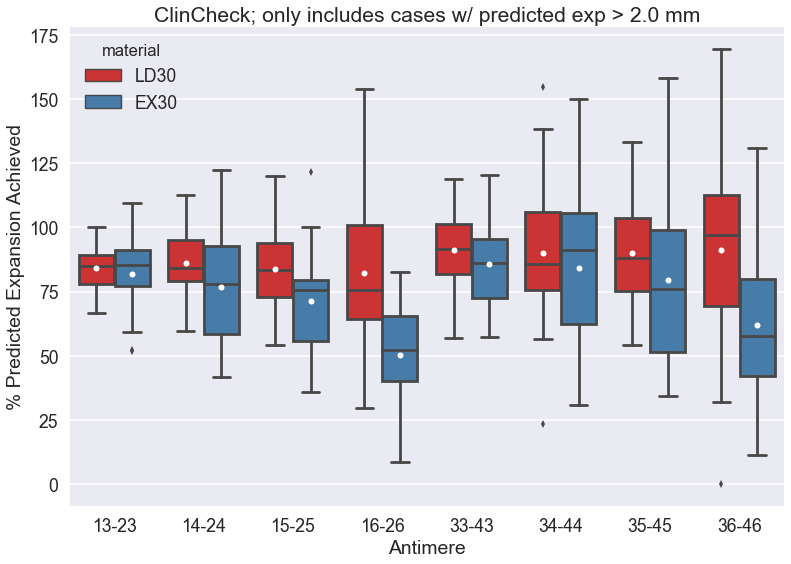

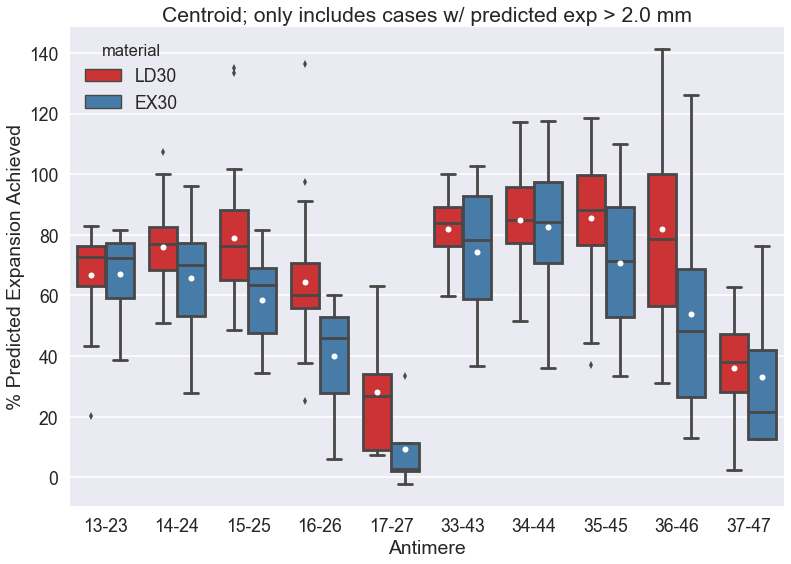

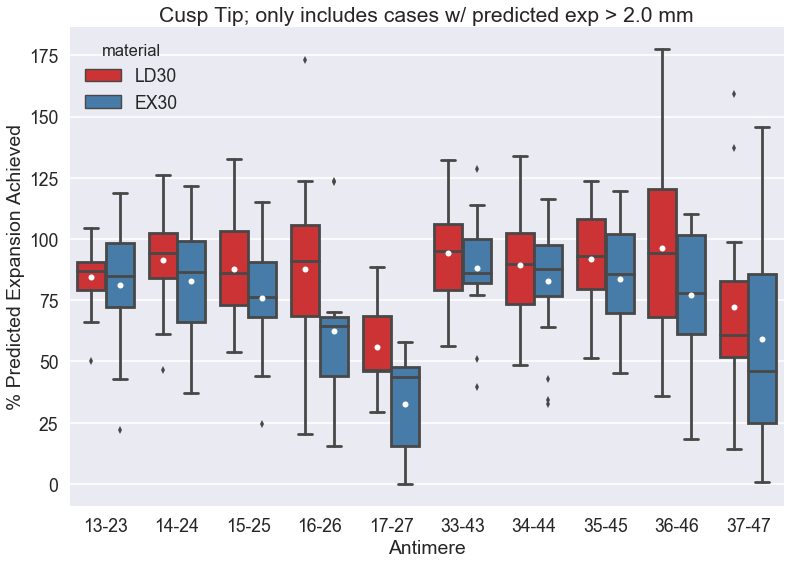

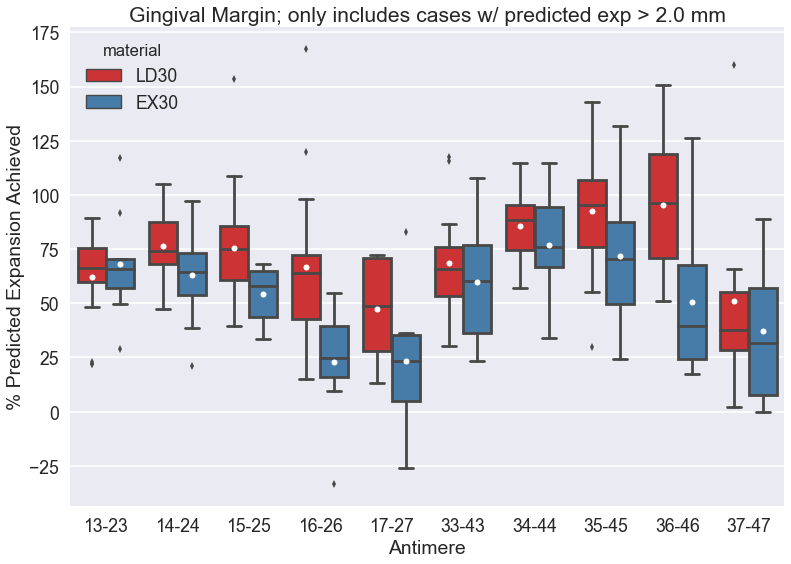

In [16]:
def groupedBoxPlot(df, measure_type, threshold):
    '''Grouped Boxplot: %Accuracy vs Antimere grouped by material (LD30 vs EX30), for a given measure_type;
    Only includes data where predicted exp > threshold.
    Also outputs .PDF of data.'''
    
        
    pp = PdfPages('output/boxplots/grouped-boxplots-%s.pdf' % (measure_type))
    f = plt.figure()
    sns.set('poster', font_scale=1.1)
    
    
    newDf = pd.DataFrame(columns = ['%acc', 'antimere', 'material'])
    
    for material in ['LD30', 'EX30']:
        subDf = getSubDf(df, measure_type, THRESHOLD, material)
        for i, j in zip([1, 3], [2, 4]):
            for toothNum in range(3, 8):
                
                if measure_type == '.cc' and toothNum == 7:
                    continue
                
                antimere = '%s%s-%s%s' % (i, toothNum, j, toothNum)
                full_antimere = '%s%s-%s%s%s %%acc' % (i, toothNum, j, toothNum, measure_type)

                #antimere df
                amDf = pd.DataFrame(subDf[full_antimere].dropna())
                amDf = amDf.rename(columns = lambda x: str(x)[-4:])
                amDf['antimere'] = antimere
                amDf['material'] = material
                
                newDf = pd.concat([newDf, amDf], ignore_index=True)
    
    ax = sns.boxplot(x='antimere', y='%acc', hue='material', data=newDf, showmeans=True, palette="Set1", 
                     meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"})

    # Set titles
    ax.axes.set_title("%s; only includes cases w/ predicted exp > %s mm" % (measure_type_dict[measure_type], threshold))
    ax.set_xlabel("Antimere")
    ax.set_ylabel("% Predicted Expansion Achieved")
    sns.plt.show()
    
    pp.savefig(f, bbox_inches="tight")
    pp.close()
    
    return
for measure_type in MEASURE_TYPES:
    groupedBoxPlot(df, measure_type, THRESHOLD)

In [17]:
getColumn(df, '16-26.gm %acc', '16-26', 2, '.gm', 'EX30')

Patient ID
1821189    23.119777
1856705    17.847025
1955743    54.594595
2012257   -33.333333
2209074    25.968992
2232325    37.321937
2286253    46.428571
2448128     9.688581
Name: 16-26.gm %acc, dtype: float64